In [1]:
#import modules
from statsbombpy import sb

import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance

import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
from bs4 import BeautifulSoup
import requests

In [3]:
competitions = sb.competitions()

In [4]:
competitions

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
1,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-02-14T05:41:27.566989,None,None,2024-02-14T05:41:27.566989
2,16,4,Europe,Champions League,male,False,False,2018/2019,2023-03-07T12:20:48.118250,2021-06-13T16:17:31.694,None,2023-03-07T12:20:48.118250
3,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
4,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
...,...,...,...,...,...,...,...,...,...,...,...,...
66,55,43,Europe,UEFA Euro,male,False,True,2020,2023-02-24T21:26:47.128979,2023-04-27T22:38:34.970148,2023-04-27T22:38:34.970148,2023-02-24T21:26:47.128979
67,35,75,Europe,UEFA Europa League,male,False,False,1988/1989,2023-06-18T19:28:39.443883,2021-06-13T16:17:31.694,None,2023-06-18T19:28:39.443883
68,53,106,Europe,UEFA Women's Euro,female,False,True,2022,2023-10-24T03:36:54.066267,2023-10-24T03:37:29.085948,2023-10-24T03:37:29.085948,2023-10-24T03:36:54.066267
69,72,107,International,Women's World Cup,female,False,True,2023,2023-12-12T14:06:50.626363,2023-12-12T14:12:41.561162,2023-12-12T14:12:41.561162,2023-12-12T14:06:50.626363


In [5]:
pd.unique(competitions['competition_name'])

array(['1. Bundesliga', 'African Cup of Nations', 'Champions League',
       'Copa del Rey', "FA Women's Super League", 'FIFA U20 World Cup',
       'FIFA World Cup', 'Indian Super league', 'La Liga',
       'Liga Profesional', 'Ligue 1', 'Major League Soccer',
       'North American League', 'NWSL', 'Premier League', 'Serie A',
       'UEFA Euro', 'UEFA Europa League', "UEFA Women's Euro",
       "Women's World Cup"], dtype=object)

In [6]:
competitions[competitions['competition_name']=='La Liga']

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
36,11,90,Spain,La Liga,male,False,False,2020/2021,2023-11-15T10:25:53.245065,2023-11-15T10:29:14.475865,2023-11-15T10:29:14.475865,2023-11-15T10:25:53.245065
37,11,42,Spain,La Liga,male,False,False,2019/2020,2023-07-25T00:16:32.999467,2021-06-13T16:17:31.694,None,2023-07-25T00:16:32.999467
38,11,4,Spain,La Liga,male,False,False,2018/2019,2023-11-05T09:50:49.746684,2021-07-09T14:53:22.103024,None,2023-11-05T09:50:49.746684
39,11,1,Spain,La Liga,male,False,False,2017/2018,2023-07-24T13:03:48.574627,2021-06-13T16:17:31.694,None,2023-07-24T13:03:48.574627
40,11,2,Spain,La Liga,male,False,False,2016/2017,2023-11-14T18:26:44.671413,2021-06-13T16:17:31.694,None,2023-11-14T18:26:44.671413
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
42,11,26,Spain,La Liga,male,False,False,2014/2015,2023-09-20T17:22:28.925900,2021-06-13T16:17:31.694,None,2023-09-20T17:22:28.925900
43,11,25,Spain,La Liga,male,False,False,2013/2014,2022-07-23T12:18:49.547396,2021-06-13T16:17:31.694,None,2022-07-23T12:18:49.547396
44,11,24,Spain,La Liga,male,False,False,2012/2013,2022-09-25T20:52:24.444609,2021-06-13T16:17:31.694,None,2022-09-25T20:52:24.444609
45,11,23,Spain,La Liga,male,False,False,2011/2012,2022-12-01T14:10:17.791769,2021-06-13T16:17:31.694,None,2022-12-01T14:10:17.791769


In [7]:
Ligue1_22 = sb.matches(competition_id=11, season_id=90)
Ligue1_22

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3773386,2020-10-31,21:00:00.000,Spain - La Liga,2020/2021,Deportivo Alavés,Barcelona,1,1,available,...,2023-07-25T04:25:41.348202,8,Regular Season,Estadio de Mendizorroza,NaN,Pablo Javier Machín Díez,Ronald Koeman,1.1.0,2,2
1,3773565,2021-01-09,18:30:00.000,Spain - La Liga,2020/2021,Granada,Barcelona,0,4,available,...,2023-07-25T04:30:16.058384,18,Regular Season,Estadio Nuevo Los Cármenes,Ricardo De Burgos Bengoetxea,Diego Martínez Penas,Ronald Koeman,1.1.0,2,2
2,3773457,2021-05-16,18:30:00.000,Spain - La Liga,2020/2021,Barcelona,Celta Vigo,1,2,available,...,2023-04-27T23:03:53.506485,37,Regular Season,Spotify Camp Nou,NaN,Ronald Koeman,Eduardo Germán Coudet,1.1.0,2,2
3,3773631,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,...,2023-07-25T03:56:34.733180,22,Regular Season,Estadio Benito Villamarín,NaN,Manuel Luis Pellegrini Ripamonti,Ronald Koeman,1.1.0,2,2
4,3773665,2021-03-06,21:00:00.000,Spain - La Liga,2020/2021,Osasuna,Barcelona,0,2,available,...,2023-04-28T02:57:03.412841,26,Regular Season,Estadio El Sadar,Guillermo Cuadra Fernández,Jagoba Arrasate Elustondo,Ronald Koeman,1.1.0,2,2
5,3773497,2021-04-10,21:00:00.000,Spain - La Liga,2020/2021,Real Madrid,Barcelona,2,1,available,...,2023-04-28T01:35:16.051381,30,Regular Season,Estadio Alfredo Di Stéfano,Jesús Gil Manzano,Zinédine Zidane,Ronald Koeman,1.1.0,2,2
6,3773660,2020-12-13,21:00:00.000,Spain - La Liga,2020/2021,Barcelona,Levante UD,1,0,available,...,2023-04-28T06:01:10.173360,13,Regular Season,Spotify Camp Nou,Ricardo De Burgos Bengoetxea,Ronald Koeman,Francisco José López Fernández,1.1.0,2,2
7,3773593,2020-09-27,21:00:00.000,Spain - La Liga,2020/2021,Barcelona,Villarreal,4,0,available,...,2023-07-25T04:44:03.367478,3,Regular Season,Spotify Camp Nou,Guillermo Cuadra Fernández,Ronald Koeman,Unai Emery Etxegoien,1.1.0,2,2
8,3773466,2020-10-01,21:30:00.000,Spain - La Liga,2020/2021,Celta Vigo,Barcelona,0,3,available,...,2023-07-25T04:40:53.635540,4,Regular Season,Abanca-Balaídos,Carlos del Cerro Grande,Óscar García Junyent,Ronald Koeman,1.1.0,2,2
9,3773585,2020-10-24,16:00:00.000,Spain - La Liga,2020/2021,Barcelona,Real Madrid,1,3,available,...,2023-07-25T04:29:21.140321,7,Regular Season,Spotify Camp Nou,Juan Martínez Munuera,Ronald Koeman,Zinédine Zidane,1.1.0,2,2


In [8]:
competitions[
    (competitions['competition_name'].isin([
    'Premier League', '1. Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']))
             & 
    (competitions['season_name']=='2015/2016')
            ]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
58,7,27,France,Ligue 1,male,False,False,2015/2016,2023-12-13T00:27:57.162379,None,None,2023-12-13T00:27:57.162379
62,2,27,England,Premier League,male,False,False,2015/2016,2023-11-14T11:25:33.476498,2021-06-13T16:17:31.694,None,2023-11-14T11:25:33.476498
64,12,27,Italy,Serie A,male,False,False,2015/2016,2023-12-13T17:32:46.423081,None,None,2023-12-13T17:32:46.423081


In [9]:
#competitions[competitions['competition_name']=='Champions League']

In [10]:
Ligue1 = sb.matches(competition_id=7, season_id=27)
Ligue1.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3901199,2016-04-02,20:00:00.000,France - Ligue 1,2015/2016,Rennes,Stade de Reims,3,1,available,...,None,32,Regular Season,Roazhon Park,Saïd Ennjimi,Rolland Courbis,Olivier Guégan,1.1.0,2,2
1,3901178,2016-03-12,18:00:00.000,France - Ligue 1,2015/2016,Lorient,Marseille,1,1,available,...,None,30,Regular Season,Stade Yves Allainmat - Le Moustoir,Ruddy Buquet,Sylvain Ripoll,José Miguel González Martín del Campo,1.1.0,2,2
2,3901260,2016-05-14,21:00:00.000,France - Ligue 1,2015/2016,Lorient,Gazélec Ajaccio,1,0,available,...,None,38,Regular Season,Stade Yves Allainmat - Le Moustoir,Benoît Millot,Sylvain Ripoll,Thierry Laurey,1.1.0,2,2
3,3829470,2015-09-20,17:00:00.000,France - Ligue 1,2015/2016,Saint-Étienne,Nantes,2,0,available,...,None,6,Regular Season,Stade Geoffroy-Guichard,Benoît Millot,Christophe Galtier,Michel Der Zakarian,1.1.0,2,2
4,3901259,2016-05-14,21:00:00.000,France - Ligue 1,2015/2016,Troyes,Marseille,1,1,available,...,None,38,Regular Season,Stade de l''Aube,François Letexier,Mohamed Bradja,Franck Passi,1.1.0,2,2


In [11]:
Ligue1.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

In [12]:
print(pd.unique(Ligue1['home_team']))

['Rennes' 'Lorient' 'Saint-Étienne' 'Troyes' 'Nantes' 'Bastia' 'Guingamp'
 'Paris Saint-Germain' 'Marseille' 'Lille' 'Gazélec Ajaccio' 'Caen'
 'AS Monaco' 'Angers' 'Stade de Reims' 'Bordeaux' 'Lyon' 'OGC Nice'
 'Montpellier' 'Toulouse']


In [13]:
# elevations = {'King Power Stadium ': 57, 'The Hawthorns': 166, "St. James'' Park": 78, 'Goodison Park': 47,
#  'Selhurst Park': 54, 'Emirates Stadium': 31, 'White Hart Lane': 20, 'Stadium of Light': 40,
#  'Villa Park': 105, 'Anfield ': 66, 'bet365 Stadium': 131, 'Old Trafford':43,
#  'Vitality Stadium': 33,'Swansea.com Stadium': 15, "St. Mary''s Stadium": 1,
#  'Carrow Road': 7, 'Stamford Bridge':11, 'Vicarage Road':70, 'Etihad Stadium': 60,
#  'Boleyn Ground':11}

In [14]:
Ligue1.iloc[0]

match_id                                    3901199
match_date                               2016-04-02
kick_off                               20:00:00.000
competition                        France - Ligue 1
season                                    2015/2016
home_team                                    Rennes
away_team                            Stade de Reims
home_score                                        3
away_score                                        1
match_status                              available
match_status_360                        unscheduled
last_updated             2023-11-14T11:49:10.184615
last_updated_360                               None
match_week                                       32
competition_stage                    Regular Season
stadium                                Roazhon Park
referee                                Saïd Ennjimi
home_managers                       Rolland Courbis
away_managers                        Olivier Guégan
data_version

In [15]:
example = sb.events(match_id=3754037)
example.columns

Index(['ball_receipt_outcome', 'ball_recovery_offensive',
       'ball_recovery_recovery_failure', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
   

In [16]:
relevant_attributes = ['minute', 'second', 'team', 'shot_statsbomb_xg',
                       'player', 'position', 'location', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 
         'shot_technique',
       'shot_type', 'type','shot_outcome']

In [17]:
# check_attributes = ['pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
#        'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
#        'pass_inswinging', 'pass_length', 'pass_no_touch', 'pass_outcome',
#        'pass_outswinging', 'pass_recipient', 'pass_recipient_id',
#        'pass_shot_assist', 'pass_straight', 'pass_switch', 'pass_technique',
#        'pass_type', 'type', 'shot_outcome', 'location']
# first_match_df = pd.DataFrame(columns=check_attributes)
# for match in PremierLeague['match_id'][:1]:
#     match_df = sb.events(match_id=match)
#     relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
#     first_match_df = pd.concat([first_match_df, relevant_match_df], ignore_index=True)

# first_match_df['shot_outcome'] = first_match_df['shot_outcome'].replace(to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
#                'Saved to Post': 0, 'Saved Off Target': 0})

# first_match_df['distance'] = first_match_df.apply(lambda row: np.sqrt(np.abs(row.location[0]-120)**2 + 
#                                                      np.abs(row.location[1]-40)**2), axis=1)
# first_match_df

In [18]:
Ligue1_shots_df = pd.DataFrame(columns=relevant_attributes)

In [19]:
start = time.time()
for match in Ligue1['match_id']:#[:10]:
    match_df = sb.events(match_id=match)
    relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
    Ligue1_shots_df = pd.concat([Ligue1_shots_df, relevant_match_df], ignore_index=True)

Ligue1_shots_df['shot_outcome'] = Ligue1_shots_df['shot_outcome'].replace(
    to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
               'Saved to Post': 0, 'Saved Off Target': 0})

Ligue1_shots_df['distance'] = Ligue1_shots_df.apply(lambda row: np.sqrt(np.abs(
    row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
Ligue1_shots_df['shot_angle'] = Ligue1_shots_df.apply(
    lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
end = time.time()
print(f'script run time: {(end - start)/60} minutes')
Ligue1_shots_df

script run time: 5.9500271002451575 minutes


,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,distance,shot_angle
0,11,28,Rennes,0.228253,Kamil Grosicki,Right Wing,"[106.3, 34.4]",Right Foot,"[120.0, 38.9, 0.3]",True,Normal,Open Play,Shot,1,14.800338,0.388034
1,14,1,Rennes,0.185508,Ousmane Dembélé,Center Attacking Midfield,"[109.2, 33.8]",Right Foot,"[120.0, 41.9, 0.2]",NaN,Normal,Open Play,Shot,1,12.453112,0.521138
2,39,33,Stade de Reims,0.033825,Diego Rigonato Rodrigues,Left Wing Back,"[91.5, 53.0]",Left Foot,"[100.3, 49.9]",NaN,Normal,Free Kick,Shot,0,31.324910,0.427948
3,39,42,Stade de Reims,0.018544,Nicolas de Roussel de Préville,Left Center Forward,"[90.5, 52.5]",Right Foot,"[120.0, 46.5, 0.6]",True,Volley,Open Play,Shot,0,32.039039,0.400793
4,45,52,Rennes,0.011751,Kamil Grosicki,Right Wing,"[100.9, 59.7]",Right Foot,"[119.3, 38.5, 2.1]",NaN,Normal,Free Kick,Shot,0,27.439023,0.800861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8809,86,27,Marseille,0.023326,Bouna Sarr,Center Attacking Midfield,"[94.8, 29.0]",Right Foot,"[100.3, 31.4]",NaN,Normal,Open Play,Shot,0,27.496182,0.411577
8810,86,30,Marseille,0.041235,Georges-Kévin Nkoudou Mbida,Right Wing,"[106.6, 55.5]",Right Foot,"[120.0, 34.6, 0.8]",NaN,Normal,Open Play,Shot,0,20.489265,0.857935
8811,87,53,Marseille,0.069342,Abdelaziz Barrada,Left Defensive Midfield,"[99.0, 39.5]",Right Foot,"[119.0, 43.0, 0.2]",NaN,Normal,Open Play,Shot,0,21.005952,0.023805
8812,88,44,Caen,0.289594,Andy Delort,Center Forward,"[108.5, 29.3]",Right Foot,"[120.0, 35.2, 0.2]",NaN,Normal,Open Play,Shot,0,15.707960,0.749378


## Describing the Data

In [20]:
Ligue1_shots_df.describe()

,shot_statsbomb_xg,shot_outcome,distance,shot_angle
count,8814.000000,8814.000000,8814.000000,8814.000000
mean,0.099264,0.103926,19.720566,0.479071
std,0.140112,0.305181,9.085389,0.323487
min,0.000180,0.000000,1.702939,0.000000
25%,0.025757,0.000000,12.146604,0.210712
50%,0.051258,0.000000,18.909521,0.442388
75%,0.104207,0.000000,26.413822,0.703946
max,0.976663,1.000000,78.408227,1.560619


In [21]:
Ligue1_shots_df = Ligue1_shots_df[Ligue1_shots_df.shot_type != 'Corner']

In [22]:
Ligue1_shots_df['shot_outcome'].value_counts()

shot_outcome
0    7896
1     915
Name: count, dtype: int64

In [23]:
Ligue1_team_summary_df = pd.DataFrame(columns = ['team', 'shots', 'goals', 'statsbomb_xg'])
for team in pd.unique(Ligue1_shots_df['team']):
    shot_sum = Ligue1_shots_df['team'].value_counts()[team]
    goal_sum = sum(Ligue1_shots_df[Ligue1_shots_df['team']==team]['shot_outcome'])
    statsbomb_xg_sum = sum(Ligue1_shots_df[Ligue1_shots_df['team']==team]['shot_statsbomb_xg'])
    new_row = pd.Series({'team': team, 'shots': shot_sum, 'goals': goal_sum, 'statsbomb_xg': statsbomb_xg_sum})
    Ligue1_team_summary_df.loc[len(Ligue1_team_summary_df)]=new_row
Ligue1_team_summary_df = Ligue1_team_summary_df.sort_values(by=['shots'], ascending=False)
Ligue1_team_summary_df

,team,shots,goals,statsbomb_xg
10,Lyon,559,65,61.565376
13,Paris Saint-Germain,553,99,76.937309
17,Lille,489,38,37.673611
3,Marseille,485,48,50.191697
18,Caen,481,38,41.696027
5,Nantes,440,30,35.599751
1,Stade de Reims,440,43,42.61836
16,Toulouse,437,43,50.899083
6,Saint-Étienne,436,39,42.489186
7,Troyes,432,25,31.940842


In [24]:
Ligue1_shots_df.columns

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'distance',
       'shot_angle'],
      dtype='object')

## Split training and test data, train model and define functions

In [25]:
cap_x_df, y_df = pd.concat([Ligue1_shots_df.iloc[:,:-3], Ligue1_shots_df.iloc[:,-2:]], axis=1),Ligue1_shots_df.iloc[:,-3].to_frame()

In [26]:
train_cap_x_df, test_cap_x_df, train_y_df, test_y_df = \
train_test_split(cap_x_df, y_df,
                 test_size=0.20,
                random_state=42,
                 shuffle=True,
                stratify=y_df)

In [27]:
target_attr = 'shot_outcome'

In [28]:
numerical_attrs = ['distance', 'minute', 'shot_angle']

In [29]:
nominal_attrs = ['shot_technique', 'shot_type', 'shot_body_part', 'position', 'shot_first_time', 'position']

In [30]:
numerical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer()),
               ("scaler", StandardScaler())]
    )

In [31]:
nominal_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent")),
               #('target_encoder', TargetEncoder(target_type=target_type, random_state=42)),
               ("target_encoder", OrdinalEncoder()),
               ("scaler", StandardScaler())
               ]
    )

In [32]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attrs),
            ('nominal', nominal_transformer, nominal_attrs)
        ]
    )

### The function below will be used to compare our models to the statsbomb model

In [ ]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    #.legend(label=outcome
    z = np.polyfit(model1, model2,1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

## Try with Logistic Regression

In [33]:
estimator = LogisticRegression()

In [34]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [35]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator', LogisticRegression())])

In [36]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.9451451 , 0.0548549 ],
       [0.89735698, 0.10264302],
       [0.96243793, 0.03756207],
       ...,
       [0.95168362, 0.04831638],
       [0.92999469, 0.07000531],
       [0.92651571, 0.07348429]])

In [37]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    6316
1     732
Name: count, dtype: int64
Training set naive model total xG 732.0043224353559
Training set Statsbomb total xG: 702.3164847795998


In [39]:
pd.unique(Ligue1_shots_df['shot_type'])

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [40]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [41]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1580
1     183
Name: count, dtype: int64
Test set naive model total xG 180.44110376344253
Statsbomb total xG: 172.59227559889976


In [42]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1580
1     183
Name: count, dtype: int64


In [43]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 172.59227559889976


In [44]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.06x+-0.01
$R^2$= 0.08322792288067904


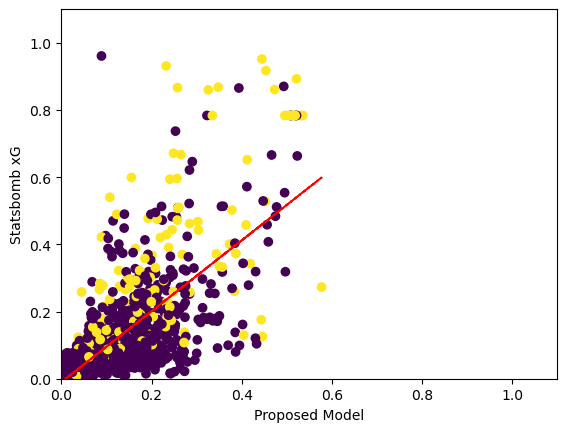

In [45]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

In [46]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'proposed_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
proposed_model_xg = sum(test_predictions[:,1])
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'proposed_model_xg': proposed_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,proposed_model_xg
0,1763.0,183.0,172.592276,180.441104


## Try with SGDClassifier

In [47]:
estimator = SGDClassifier(
        loss='log_loss', 
        penalty='l2', 
        alpha=0.0001, 
        l1_ratio=0.15, 
        fit_intercept=True, 
        max_iter=1000, 
        tol=0.001, 
        shuffle=True, 
        verbose=0, 
        epsilon=0.1, 
        n_jobs=None, 
        random_state=42, 
        learning_rate='optimal', 
        eta0=0.0, 
        power_t=0.5, 
        early_stopping=False, 
        validation_fraction=0.1, 
        n_iter_no_change=5, 
        class_weight=None, 
        warm_start=False, 
        average=False
    )

In [48]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [49]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator', SGDClassifier(loss='log_loss', random_state=42))])

In [50]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.95827492, 0.04172508],
       [0.91805767, 0.08194233],
       [0.95121484, 0.04878516],
       ...,
       [0.95809288, 0.04190712],
       [0.94441058, 0.05558942],
       [0.94523265, 0.05476735]])

In [51]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    6316
1     732
Name: count, dtype: int64
Training set naive model total xG 641.7210182258532
Training set Statsbomb total xG: 702.3164847795998


In [53]:
pd.unique(Ligue1_shots_df['shot_type'])

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [54]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [55]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1580
1     183
Name: count, dtype: int64
Test set naive model total xG 161.45567151275546
Statsbomb total xG: 172.59227559889976


In [56]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1580
1     183
Name: count, dtype: int64


In [57]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 172.59227559889976


In [58]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.02x+0.00
$R^2$= -0.5783630881129156


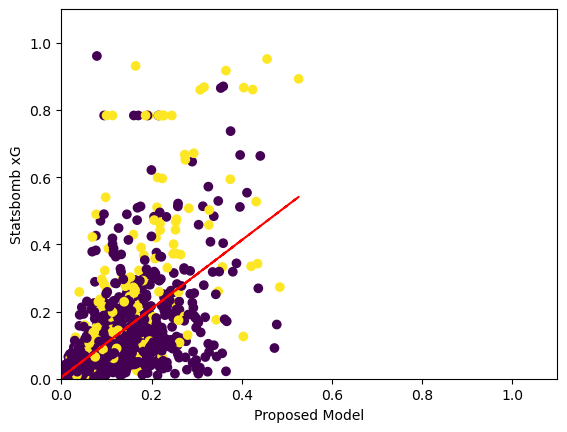

In [59]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

In [60]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'proposed_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
proposed_model_xg = sum(test_predictions[:,1])
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'proposed_model_xg': proposed_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,proposed_model_xg
0,1763.0,183.0,172.592276,161.455672


## Try with RandomForest Classifier

In [61]:
estimator = RandomForestClassifier(
    n_estimators=500, 
    criterion='gini', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt', 
    max_leaf_nodes=16, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1, 
    random_state=42,
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)

In [62]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [63]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'minute',
                                                   'shot_angle']),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['shot_technique',
                                                   'shot_type',
                                                   'shot_body_part', 'position',
                                                   'shot_first_time',
                                                   'position'])])),
                ('estimator',
                 RandomForestClassifier(max_leaf_nodes=16, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

In [64]:
composite_estimator.predict_proba(train_cap_x_df)

array([[0.93299785, 0.06700215],
       [0.88414376, 0.11585624],
       [0.92645448, 0.07354552],
       ...,
       [0.93070586, 0.06929414],
       [0.92177268, 0.07822732],
       [0.92995258, 0.07004742]])

In [65]:
print("Training set actual goal information")
print(train_y_df[target_attr].value_counts())
print("Training set naive model total xG",sum(composite_estimator.predict_proba(train_cap_x_df)[:,1]))
print("Training set Statsbomb total xG:", sum(train_cap_x_df['shot_statsbomb_xg']))

Training set actual goal information
shot_outcome
0    6316
1     732
Name: count, dtype: int64
Training set naive model total xG 731.2176286756605
Training set Statsbomb total xG: 702.3164847795998


In [67]:
pd.unique(Ligue1_shots_df['shot_type'])

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [68]:
test_predictions = composite_estimator.predict_proba(test_cap_x_df)

In [69]:
print("Test set actual goal information")
print(test_y_df[target_attr].value_counts())
print("Test set naive model total xG", sum(test_predictions[:,1]))
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Test set actual goal information
shot_outcome
0    1580
1     183
Name: count, dtype: int64
Test set naive model total xG 184.47077586591996
Statsbomb total xG: 172.59227559889976


In [70]:
print(test_y_df[target_attr].value_counts())

shot_outcome
0    1580
1     183
Name: count, dtype: int64


In [71]:
print("Statsbomb total xG:", sum(test_cap_x_df['shot_statsbomb_xg']))

Statsbomb total xG: 172.59227559889976


In [72]:
SBModel = test_cap_x_df['shot_statsbomb_xg']
proposed_model = test_predictions[:,1]
shot_outcome = test_y_df[target_attr]

y=1.17x+-0.02
$R^2$= -0.05247594800505384


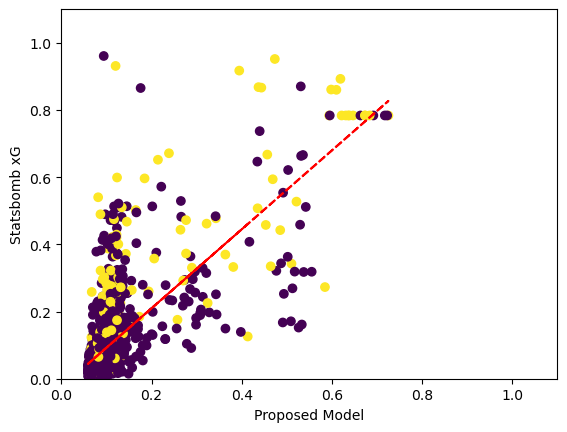

In [73]:
plot_comparison(proposed_model, "Proposed Model", SBModel, 'Statsbomb xG', shot_outcome)

In [74]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'proposed_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
proposed_model_xg = sum(test_predictions[:,1])
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'proposed_model_xg': proposed_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,proposed_model_xg
0,1763.0,183.0,172.592276,184.470776
